In [1]:
import sys; from pathlib import Path
src_dir = next(parent / 'src' for parent in Path().absolute().parents if (parent / 'src').is_dir())
sys.path.extend([str(src_dir), str(src_dir / 'pipelines')])
from imports import * ; current_dir = Path().resolve()
folder_outputs = create_output_folder('Figures_Simple_Gene_Expression')

# Model Gene Expression
____

For a simple gene expression model where gene expression involves transcription and mRNA degradation without feedback mechanisms, we can describe the process using the following two reactions: 

### Reactions

1. **Transcription**: This is the process by which mRNA is synthesized from the gene.
   $$\text{Gene} \xrightarrow{k_r} \text{Gene} + \text{mRNA}$$
   - $k_r$ is the rate constant for transcription.

2. **Degradation of mRNA**: This represents the decay or degradation of mRNA molecules into nothing (denoted by $\emptyset$).
   $$\text{mRNA} \xrightarrow{\gamma_r} \emptyset$$
   - $\gamma_r$ is the rate constant for mRNA degradation.

____

### Reactions simplified model (assuming the gene is a constant)

1. **Transcription**: In the simplified model, we absorb the constant gene copy assumption into a single effective reaction.
   $$\emptyset \xrightarrow{k_r} \text{mRNA}$$
   - $k_r$ is the rate constant for transcription.

2. **Degradation of mRNA**: This represents the decay or degradation of mRNA molecules into nothing (denoted by $\emptyset$).
   $$\text{mRNA} \xrightarrow{\gamma_r} \emptyset$$
   - $\gamma_r$ is the rate constant for mRNA degradation.


# Modeling 
____

In [2]:
# class GeneExpressionModel(gillespy2.Model):
#     def __init__(self, parameter_values, initial_conditions):
#         super(GeneExpressionModel, self).__init__('SimpleGeneExpressionModel')
#         # Create and add parameters to the model
#         for name, expression in parameter_values.items():
#             self.add_parameter(gillespy2.Parameter(name=name, expression=expression))
#         # Species
#         G_on = gillespy2.Species(name='G_on', initial_value=initial_conditions.get('G_on', 1))
#         mRNA = gillespy2.Species(name='mRNA', initial_value=initial_conditions.get('mRNA', 0))
#         self.add_species([G_on, mRNA])
#         # Reactions
#         transcription = gillespy2.Reaction(name='transcription',
#                                            reactants={G_on: 1},
#                                            products={G_on: 1, mRNA: 1},
#                                            rate=self.listOfParameters['k_transcription'])
#         mRNA_decay = gillespy2.Reaction(name='mRNA_decay',
#                                         reactants={mRNA: 1},
#                                         products={},
#                                         rate=self.listOfParameters['k_mRNA_decay'])
#         self.add_reaction([transcription, mRNA_decay])
#         # Set the timespan for the model
#         self.timespan(np.linspace(0, 100, 101))


In [3]:
class GeneExpressionModel(gillespy2.Model):
    def __init__(self, parameter_values, initial_conditions):
        super(GeneExpressionModel, self).__init__('SimpleGeneExpressionModel')
        # Create and add parameters to the model
        for name, expression in parameter_values.items():
            self.add_parameter(gillespy2.Parameter(name=name, expression=expression))
        # Species
        #G_on = gillespy2.Species(name='G_on', initial_value=initial_conditions.get('G_on', 1))
        mRNA = gillespy2.Species(name='mRNA', initial_value=initial_conditions.get('mRNA', 0))
        self.add_species([mRNA])
        # Reactions
        transcription = gillespy2.Reaction(name='transcription',
                                           reactants={},
                                           products={mRNA: 1},
                                           rate=self.listOfParameters['k_transcription'])
        mRNA_decay = gillespy2.Reaction(name='mRNA_decay',
                                        reactants={mRNA: 1},
                                        products={},
                                        rate=self.listOfParameters['k_mRNA_decay'])
        self.add_reaction([transcription, mRNA_decay])
        # Set the timespan for the model
        self.timespan(np.linspace(0, 100, 101))

In [4]:
def initialize_model(parameter_values, initial_conditions):
    model = GeneExpressionModel(parameter_values, initial_conditions)
    return model

In [5]:
def simulate_gene_expression(parameter_values, initial_conditions, total_simulation_time, number_of_trajectories=1, simulation_type='stochastic'):
    # Initialize the model
    model = initialize_model(parameter_values, initial_conditions)
    # Set the timespan for the simulation
    model.timespan(np.linspace(0, total_simulation_time, total_simulation_time + 1))
    # Choose the simulation type
    if simulation_type == 'deterministic':
        solver = gillespy2.ODESolver
    elif simulation_type == 'stochastic':
        solver = gillespy2.TauLeapingSolver
    else:
        raise ValueError("simulation_type must be either 'deterministic' or 'stochastic'")
    # Run the simulation
    results = model.run(solver=solver, number_of_trajectories=number_of_trajectories)
    # Extracting results
    if simulation_type == 'deterministic':
        time = results[0]['time']
        species_concentrations = {species: results[0][species] for species in model.listOfSpecies.keys()}
    elif simulation_type == 'stochastic':
        # For stochastic simulation, we might want to process results differently
        # Here, we just take the first trajectory as an example
        time = results[0]['time']
        species_concentrations = {species: np.array([trajectory[species] for trajectory in results]) for species in model.listOfSpecies.keys()}
    return time, species_concentrations


In [6]:
#@title Plotting ODE model
def plotting_deterministic(time,concentrations_species,species_colors,ylim_val=False,save_figure=True,plot_name='det.png'):
    plt.figure(figsize=(8, 5))
    for species, color in species_colors.items():
        plt.plot(time, concentrations_species[species], color=color, label=species,lw=6)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Deterministic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0,ylim_val)
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)  
    plt.show()

In [7]:
#@title Plotting SSA model
def plotting_stochastic(time, trajectories_species,species_colors,ylim_val=False,save_figure=True,plot_name='ssa.png'):
    def plot_species_trajectories(time, trajectories_species, species_name, color):
        # Extract the trajectories for the species
        trajectories = trajectories_species[species_name]
        # Calculate the mean and standard deviation across all trajectories
        mean_trajectories = np.mean(trajectories, axis=0)
        std_trajectories = np.std(trajectories, axis=0)
        # Plot mean concentration with standard deviation as shaded area
        plt.plot(time, mean_trajectories, '-', color=color, label=species_name, lw=6)
        plt.fill_between(time, mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, color=color, alpha=0.1)
    plt.figure(figsize=(8, 5))
    # Plot each species
    for species, color in species_colors.items():
        plot_species_trajectories(time, trajectories_species, species, color)
    # Set plot details
    plt.xlabel('Time')
    plt.ylabel('Number of Molecules')
    plt.title('Stochastic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0,ylim_val)
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)  
    plt.show()

In [8]:
def plotting_stochastic_trajectories(time, trajectories_species, species_colors, ylim_val=False, save_figure=False, plot_name='ssa.png'):
    def plot_species_trajectories(time, trajectories_species, species_name, color):
        # Extract the trajectories for the species
        trajectories = trajectories_species[species_name]
        # Randomly select a trajectory to highlight
        highlighted_trajectory_index = random.randint(0, trajectories.shape[0] - 1)
        # Plot each trajectory with a thin line
        for i, traj in enumerate(trajectories):
            lw = 4 if i == highlighted_trajectory_index else 1  # Thicker line for the selected trajectory
            alpha = 1.0 if i == highlighted_trajectory_index else 0.25  # More opaque for the highlighted
            plt.plot(time, traj, '-', color=color, lw=lw, alpha=alpha)
        # Add label only to the highlighted trajectory for the legend
        plt.plot([], [], '-', color=color, label=species_name, lw=4)
    plt.figure(figsize=(8, 5))
    # Plot each species
    for species, color in species_colors.items():
        plot_species_trajectories(time, trajectories_species, species, color)
    # Set plot details
    plt.xlabel('Time')
    plt.ylabel('Number of Molecules')
    plt.title('Stochastic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0, ylim_val)
    if save_figure: 
        plt.savefig(plot_name, dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)  
    plt.show()

In [9]:
# Parameters and initial conditions
k_transcription = 2 # Rate of transcription per active gene
k_mRNA_decay = 0.1  # Rate of mRNA decay
max_mRNA = 50  # Maximum number of mRNA molecules to consider in the model
total_simulation_time = 100  # Total time of simulation

In [10]:
def plotting_stochastic_dist(time, trajectories_species, species_name, species_color_dist, time_points, ylim_val=False,save_figure=True,plot_name='ssa_dist.png'):
    def plot_species_trajectories(ax, time, trajectories_species, species_name, color, time_point):
        # Extract the trajectories for the species at the specific time point
        trajectories = trajectories_species[species_name][:, time_point]
        # Plot distribution of species count at the specified time point
        ax.hist(trajectories, bins=20, color=color, alpha=0.7, label=f"{species_name} at time={time[time_point]}")
        ax.legend(loc='upper right')
    # Set up a 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(8, 5))
    axs = axs.flatten()  # Flatten the 2x2 array to easily loop over it
    # Plot the species distribution at each of the four user-selected time points
    for i, time_point in enumerate(time_points):
        plot_species_trajectories(axs[i], time, trajectories_species, species_name, species_color_dist, time_point)
        axs[i].set_xlabel('Number of Molecules')
        axs[i].set_ylabel('Frequency')
        if ylim_val:
            axs[i].set_ylim(0, ylim_val)
    # Set a general title
    plt.suptitle(f'Distribution of {species_name} at Different Time Points')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplots to fit into the figure area
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)  
    plt.show()

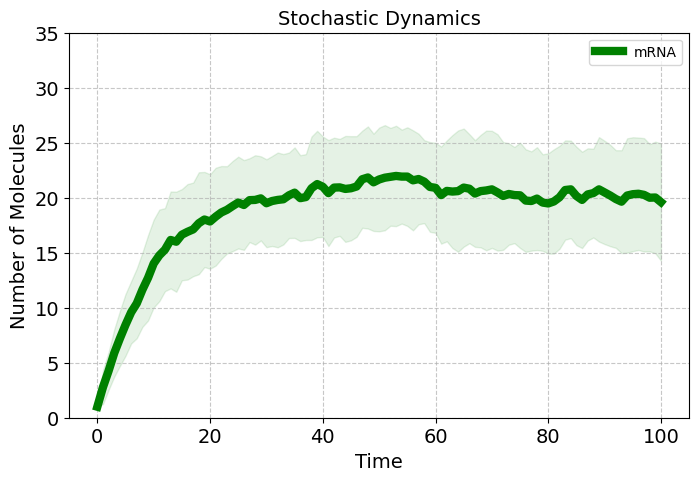

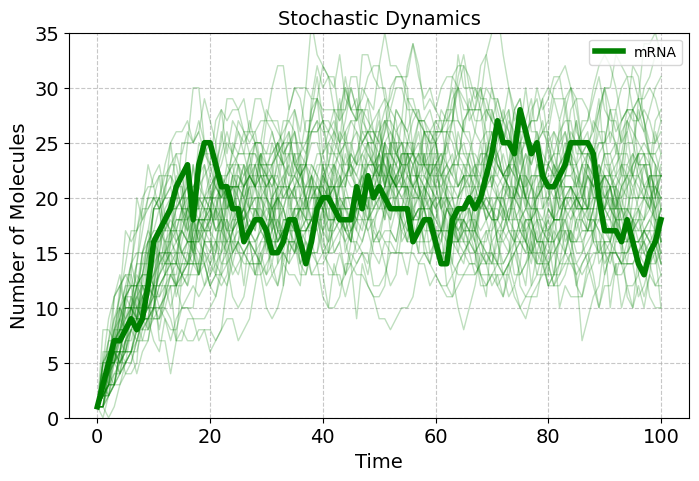

In [11]:
parameter_values = {
    'k_transcription': k_transcription,  # Rate of transcription per active gene
    'k_mRNA_decay': k_mRNA_decay  # Rate of mRNA decay
}
initial_conditions = {
    #'G_on': 1,  # Assuming the gene is always active
    'mRNA': 1  # Initial amount of mRNA
}

# Run deterministic simulation
time_det, concentrations_det = simulate_gene_expression(parameter_values, initial_conditions, total_simulation_time, simulation_type='deterministic')
# Run stochastic simulation
time_sto, concentrations_sto = simulate_gene_expression(parameter_values, initial_conditions, total_simulation_time, number_of_trajectories=50, simulation_type='stochastic')
# Plot deterministic simulation
#species_colors = {'mRNA': 'green'}
#plotting_deterministic(time_det, concentrations_det, species_colors,ylim_val=35,save_figure=True,plot_name='det.png')
# Plot stochastic simulation
species_colors = {'mRNA': 'green'}
plotting_stochastic(time_sto, concentrations_sto, species_colors,ylim_val=35,save_figure=True,plot_name='ssa.png')
# Plot stochastic simulation
plotting_stochastic_trajectories(time_sto, concentrations_sto, species_colors, ylim_val=35, save_figure=True, plot_name='ssa_trajectories.png')

# Chemical Master Equation (CME)
_____

Given these reactions, the CME for the number of mRNA molecules $m$ at time $t$ can be expressed as:
$$\frac{dP(m, t)}{dt} = k_r \cdot P(m-1, t) - k_r \cdot P(m, t) + \gamma_r \cdot (m+1) \cdot P(m+1, t) - \gamma_r \cdot m \cdot P(m, t)$$

Where:
- $P(m, t)$ is the probability of having $m$ mRNA molecules at time $t$.
- The term $k_r \cdot P(m-1, t)$ represents the rate of transition from having $m-1$ mRNA molecules to $m$ molecules due to transcription.
- The term $- k_r \cdot P(m, t)$ accounts for the transition out of state $m$ due to transcription.
- The term $\gamma_r \cdot (m+1) \cdot P(m+1, t)$ represents the increase in probability of having $m$ molecules due to the degradation of one molecule from an $m+1$ state.
- The term $- \gamma_r \cdot m \cdot P(m, t)$ accounts for the decrease in probability due to the degradation of an mRNA molecule from the state $m$.
  
## Deduction of the Steady-State Solution

The deduction of the steady-state distribution of mRNA molecules using the Chemical Master Equation (CME) involves a series of mathematical steps to transition from the equation's initial form to its steady-state solution. Here is a more detailed breakdown of these steps, including intermediate equations:

1. **Start with the balance equation at steady state**: The steady state of the system is characterized by setting the time derivative of the probability distribution to zero. This results in an equation that equates the rates of change due to transcription and degradation:
   $$0 = k_r \cdot P(m-1, t) - k_r \cdot P(m, t) + \gamma_r \cdot (m+1) \cdot P(m+1, t) - \gamma_r \cdot m \cdot P(m, t)$$
   Rearranging terms to group together the probabilities:
   $$k_r \cdot P(m-1) + \gamma_r \cdot (m+1) \cdot P(m+1) = (k_r + \gamma_r \cdot m) \cdot P(m)$$
   This equation represents a balance between the incoming and outgoing transitions for the state $m$ at steady state.

2. **Express $P(m)$ recursively in terms of $P(0)$**: To find a recursive relationship, we start by rearranging the balance equation to express $P(m+1)$ in terms of $P(m)$ and $P(m-1)$:
   $$P(m+1) = \frac{(k_r + \gamma_r \cdot m) \cdot P(m) - k_r \cdot P(m-1)}{\gamma_r \cdot (m+1)}$$
   By systematically applying this relationship starting from $m = 0$ upwards, we can express $P(m)$ in terms of $P(0)$ through a series of substitutions, each step increasing $m$ by 1.

3. **Intermediate step to simplify $P(m)$ expression**:
   Through the recursive application, we identify a pattern that emerges in the coefficients of $P(0)$ when expressing $P(m)$. This pattern is governed by the ratio of the rate constants and the factorial of $m$:
   $$P(m) = P(0) \cdot \prod_{i=1}^{m} \frac{k_r}{\gamma_r \cdot i} = P(0) \cdot \left(\frac{k_r}{\gamma_r}\right)^m \cdot \frac{1}{m!}$$
   This equation highlights the step-by-step buildup of the probability for any $m$ based on the initial probability $P(0)$ and the relationship between the rate constants.

4. **Find $P(0)$ using normalization**:
   Applying the normalization condition ensures that the sum of all probabilities equals 1:
   $$\sum_{m=0}^{\infty} P(m) = 1$$
   Substituting the expression for $P(m)$ and solving for $P(0)$ gives:
   $$P(0) = \left(\sum_{m=0}^{\infty} \left(\frac{k_r}{\gamma_r}\right)^m \cdot \frac{1}{m!}\right)^{-1}$$
   Recognizing the sum as the series expansion of $e^{\lambda}$, where $\lambda = \frac{k_r}{\gamma_r}$, simplifies $P(0)$ to:
   $$P(0) = e^{-\lambda}$$

5. **Derive the expression for $P(m)$**:
   With $P(0)$ determined, we can finalize the expression for $P(m)$, reflecting the Poisson distribution:
   $$P(m) = \frac{\lambda^m e^{-\lambda}}{m!}$$
   This equation demonstrates that the steady-state distribution for the number of mRNA molecules in this system follows a Poisson distribution with parameter $\lambda = \frac{k_r}{\gamma_r}$.

6. **Resulting Steady-State Distribution**:

   The final form of $P(m)$ confirms that at steady state, the distribution of mRNA molecules is indeed a Poisson distribution, which is commonly used to model the number of events happening within a fixed interval of time, given a constant mean rate of occurrence ($\lambda$) and independence of events. Here, $\lambda$ represents the average number of mRNA molecules, linking biological processes to statistical properties.

### Citation
_____

Hallen, M., Li, B., Tanouchi, Y., Tan, C., West, M. and You, L., 2011. Computation of steady-state probability distributions in stochastic models of cellular networks. PLoS Computational Biology, 7(10), p.e1002209. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002209

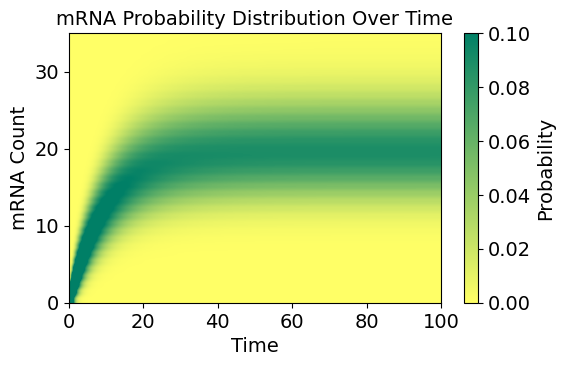

In [12]:
# The system of ODEs representing the CME
def cme(t, p):
    dpdt = np.zeros_like(p)
    for i in range(max_mRNA + 1):
        if i < max_mRNA:
            dpdt[i] += k_transcription * p[i - 1] if i > 0 else 0
            dpdt[i] -= k_transcription * p[i]
        dpdt[i] += k_mRNA_decay * (i + 1) * p[i + 1] if i < max_mRNA else 0
        dpdt[i] -= k_mRNA_decay * i * p[i]
    return dpdt
# Initial condition: all probability in state 0 (no mRNA)
p0 = np.zeros(max_mRNA + 1)
p0[0] = 1.0
t_span = (0, total_simulation_time)
t_eval = np.linspace(*t_span, 1000)
# Solve the CME
solution = solve_ivp(cme, t_span, p0, t_eval=t_eval, method='RK45')
# Plotting the probability distribution as a heatmap
plt.figure(figsize=(6, 3.5))
# Use 'imshow' for plotting the heatmap. Transpose solution.y to match dimensions (time on x-axis, mRNA count on y-axis)
plt.imshow(solution.y, aspect='auto', origin='lower', extent=[solution.t[0], solution.t[-1], 0, max_mRNA], cmap='summer_r',vmin=0, vmax=0.1)
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('mRNA Count')
plt.title('mRNA Probability Distribution Over Time')
plt.ylim(0, 35)
plt.show()

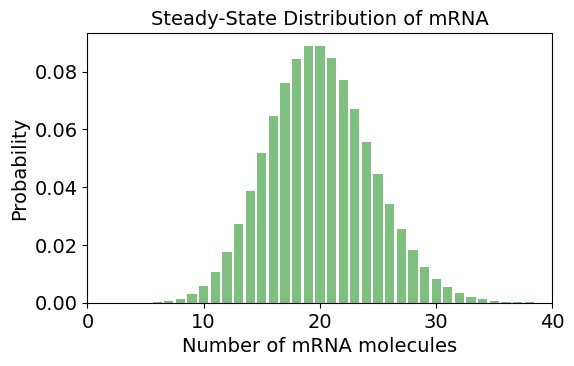

In [13]:
# Compute the mean of the Poisson distribution
lambda_ = k_transcription / k_mRNA_decay
# Generate the Poisson distribution for a range of mRNA molecule counts
mRNA_counts = np.arange(0, max_mRNA + 1)
probabilities = poisson.pmf(mRNA_counts, lambda_)

plt.figure(figsize=(6, 3.5))
# Plotting the steady-state distribution
plt.bar(mRNA_counts, probabilities, color='green', alpha=0.5)
plt.xlabel('Number of mRNA molecules')
plt.ylabel('Probability')
plt.title('Steady-State Distribution of mRNA')
plt.xlim(0, 40)
plt.show()
